[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                                  IBM        ^GSPC s_returns m_returns
Ticker                            IBM        ^GSPC                    
Date                                                                  
2010-02-28 00:00:00+00:00   72.667770  1104.489990  0.042697  0.028115
2010-03-31 00:00:00+00:00   73.290665  1169.430054  0.008535  0.057133
2010-04-30 00:00:00+00:00   73.719269  1186.689941  0.005831  0.014651
2010-05-31 00:00:00+00:00   71.948898  1089.410034 -0.024308 -0.085532
2010-06-30 00:00:00+00:00   70.926476  1030.709961 -0.014312 -0.055388
...                               ...          ...       ...       ...
2016-08-31 00:00:00+00:00  105.664017  2170.949951 -0.002292 -0.001220
2016-09-30 00:00:00+00:00  105.644058  2168.270020 -0.000189 -0.001235
2016-10-31 00:00:00+00:00  102.212341  2126.149902 -0.033023 -0.019617
2016-11-30 00:00:00+00:00  108.864021  2198.810059  0.063047  0.033604
2016-12-31 00:00:00+00:00  111.394043  2238.830078  0.022974  0.018037

[83 r

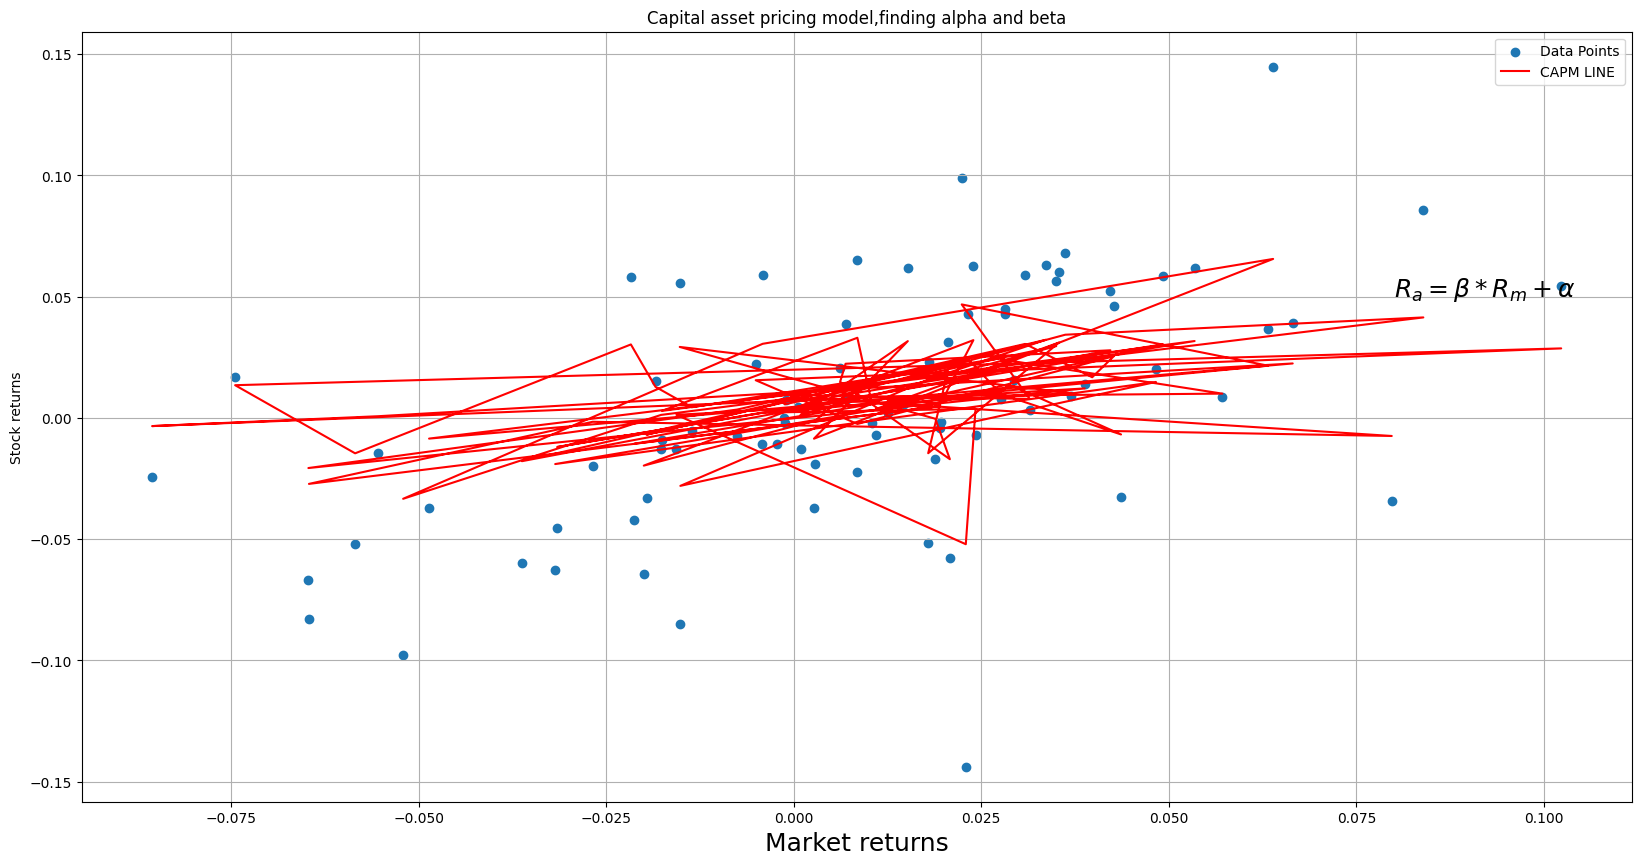

In [45]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

risk_free_rate=0.05
months_in_year=12

class CAPM:
    def __init__(self, stocks, start_date, end_date):
        self.data=[]
        self.stocks = stocks
        self.start_date = start_date
        self.end_date = end_date

    def download_data(self):
        for stock in self.stocks:
            ticker = yf.download(stock, self.start_date, self.end_date)
            if ticker.empty:  # Check if the data is empty
                print(f"Warning: No data found for {stock}")
                return None  # Return None if data for stock is empty
            self.data.append(ticker['Adj Close'])  # Append the adjusted close series for each stock
        # Merge all the series into one DataFrame, aligning by date index
        return pd.concat(self.data, axis=1, keys=self.stocks)

    def initialize(self):
        # Download the data
        stock_data = self.download_data()
        if stock_data is None:
            return  # Exit the function if data download failed

        # Resample data to the last trading day of each month
        stock_data = stock_data.resample('ME').last()  # Use the last available data of each month
        
        # Create a DataFrame from the downloaded stock data, selecting the correct columns
        self.data = stock_data[self.stocks]  # Directly select the adjusted close prices for the stocks
        
        # Calculate the log returns for both stocks
        self.data[['s_returns', 'm_returns']] = np.log(self.data / self.data.shift(1))
        
        # Drop the first row (since it's NaN for returns)
        self.data = self.data.dropna()
        self.data=pd.DataFrame(self.data)
        print(self.data)

    def calculate_beta(self):
        # Calculate covariance between the stock and market returns
        covariance_matrix = np.cov(self.data['s_returns'], self.data['m_returns'])
        beta = covariance_matrix[0, 1] / covariance_matrix[1, 1]  # Beta formula: Cov(Stock, Market) / Var(Market)
        print('Beta value is:', beta)

    def regression(self):
        beta,alpha=np.polyfit(self.data['s_returns'], self.data['m_returns'],deg=1)
        print('Beta for regression:',beta)
        expected_returns= risk_free_rate + beta*(self.data['m_returns'].mean()*months_in_year-risk_free_rate)
        print('Expected returns:',expected_returns)
        self.plot_regression(alpha,beta)

    def plot_regression(self,alpha,beta):
        fig,axis=plt.subplots(1,figsize=(20,10))
        axis.scatter(self.data['m_returns'],self.data['s_returns'],label='Data Points')
        axis.plot(self.data['m_returns'], beta*self.data['s_returns']+alpha,color='red',label='CAPM LINE')
        plt.title('Capital asset pricing model,finding alpha and beta')
        plt.xlabel('Market returns', fontsize=18)
        plt.ylabel('Stock returns')
        plt.text(0.08,0.05,r'$R_a=\beta*R_m+\alpha$',fontsize=18)
        plt.legend()
        plt.grid(True)
        plt.show()
        

if __name__ == '__main__':
    # Create an instance of CAPM with a list of stock symbols and a date range
    capm = CAPM(['IBM', '^GSPC'], '2010-01-01', '2017-01-01')
    capm.initialize()  # Initialize and download the data
    capm.calculate_beta()  # Calculate the beta based on returns
    capm.regression()
